In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from rdkit import Chem
from sklearn.model_selection import train_test_split
from rdkit.Chem import AllChem
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
def make_single_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
    return np.array(fps)

def make_inputs(df, column_name):
    inputs = np.array([])
    df.loc[pd.isna(df[column_name]) == True, [column_name]] = ''
    for smiles in df[column_name]:
        fps = make_single_fingerprint(smiles)
        inputs = np.concatenate((inputs, fps))
    return inputs.reshape([len(df), -1])

def classify_yields(df):
    average_yield = np.mean(df['yield'])
    classified = []
    for y in df['yield']:
        if y >= average_yield:
            classified.append(1)
        else:
            classified.append(0)
    df['class_yield'] = classified
    return df


def make_pca_df(df):
    pca_df = pd.DataFrame()
    smiles = (df['aryl_halide_smiles'].unique().tolist() + 
          df['ligand_smiles'].unique().tolist() + df['base_smiles'].unique().tolist() + 
          df['additive_smiles'].unique().tolist())
    labels = (['aryl halide'] * len(df['aryl_halide_smiles'].unique()) + 
         ['ligand'] * len(df['ligand_smiles'].unique()) + 
         ['base'] * len(df['base_smiles'].unique()) + 
         ['additive'] * len(df['additive_smiles'].unique()))
    pca_df['smiles'] = smiles
    pca_df['label'] = labels
    pca_df = pca_df.loc[pd.isna(pca_df['smiles']) == False]
    return pca_df

def make_pca_plot(df):
    colors = ['red', 'blue', 'black', 'purple']
    for c, l in zip(colors, pca_df['label'].unique()):
        index = pca_df.loc[pca_df['label'] == l].index
        plt.scatter(pca_df.loc[index, 'PC1'], pca_df.loc[index, 'PC2'], 
                    label=l, 
                    s=10, c=c)
    plt.title('PCA of Rxn Components')
    plt.xlabel('Prinicipal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    return plt.show()

##### Make Rxn Fingerprint Functions ######
def make_rxn_fp(rxns):
    model, tokenizer = get_default_model_and_tokenizer()
    rxnfp_generator = RXNBERTFingerprintGenerator(model, tokenizer)
    rxn_fps = []
    for rxn in rxns:
        rxn_fps.append(rxnfp_generator.convert(rxn))
    return np.array(rxn_fps).reshape([len(rxns), -1])

def make_rxn(row):
    if row['product_smiles'] == '':
        rxn = row['ligand_smiles'] + '.' + row['additive_smiles'] + '.' + row['base_smiles'] + '>>' + row['ligand_smiles']
    else:
        rxn = row['aryl_halide_smiles'] + '.' + row['ligand_smiles'] + '.' + row['additive_smiles'] +  '.' + row['base_smiles'] + '>>' + row['product_smiles']
    rxn = rxn.replace('..', '')
    if rxn[0] == '.':
        rxn = rxn[1:]
    return rxn

def make_rxn_inputs(df):
    df.loc[pd.isna(df['aryl_halide_smiles']) == True, ['aryl_halide_smiles']] = ''
    df.loc[pd.isna(df['ligand_smiles']) == True, ['ligand_smiles']] = ''
    df.loc[pd.isna(df['additive_smiles']) == True, ['additive_smiles']] = ''
    df.loc[pd.isna(df['base_smiles']) == True, ['base_smiles']] = ''
    df.loc[pd.isna(df['product_smiles']) == True, ['product_smiles']] = ''
    rxns = []
    for i in range(len(df)):
        r = make_rxn(df.iloc[i])
        rxns.append(r)
        
    rxn_inputs = make_rxn_fp(rxns)
    return rxn_inputs

In [3]:
df = pd.read_csv('doyle.csv')
df

,plate,row,col,base,base_cas_number,base_smiles,ligand,ligand_cas_number,ligand_smiles,aryl_halide_number,aryl_halide,aryl_halide_smiles,additive_number,additive,additive_smiles,product_smiles,yield
0,1,1,1,P2Et,165535-45-5,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,XPhos,564483-18-7,CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C3CCCCC3)...,1.0,1-chloro-4-(trifluoromethyl)benzene,FC(F)(F)c1ccc(Cl)cc1,NaN,NaN,NaN,Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1,26.888615
1,1,1,2,P2Et,165535-45-5,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,XPhos,564483-18-7,CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C3CCCCC3)...,2.0,1-bromo-4-(trifluoromethyl)benzene,FC(F)(F)c1ccc(Br)cc1,NaN,NaN,NaN,Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1,24.063224
2,1,1,3,P2Et,165535-45-5,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,XPhos,564483-18-7,CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C3CCCCC3)...,3.0,1-iodo-4-(trifluoromethyl)benzene,FC(F)(F)c1ccc(I)cc1,NaN,NaN,NaN,Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1,47.515821
3,1,1,4,P2Et,165535-45-5,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,XPhos,564483-18-7,CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C3CCCCC3)...,4.0,1-chloro-4-methoxybenzene,COc1ccc(Cl)cc1,NaN,NaN,NaN,COc1ccc(Nc2ccc(C)cc2)cc1,2.126831
4,1,1,5,P2Et,165535-45-5,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,XPhos,564483-18-7,CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C3CCCCC3)...,5.0,1-bromo-4-methoxybenzene,COc1ccc(Br)cc1,NaN,NaN,NaN,COc1ccc(Nc2ccc(C)cc2)cc1,47.586354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,3,32,44,MTBD,84030-20-6,CN1CCCN2CCCN=C12,AdBrettPhos,1160861-59-5,CC(C1=C(C2=C(OC)C=CC(OC)=C2P(C34CC5CC(C4)CC(C5...,12.0,2-iodopyridine,Ic1ccccn1,22.0,methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate,COC(=O)c1cc(on1)c2sccc2,Cc1ccc(Nc2ccccn2)cc1,86.233157
4595,3,32,45,MTBD,84030-20-6,CN1CCCN2CCCN=C12,AdBrettPhos,1160861-59-5,CC(C1=C(C2=C(OC)C=CC(OC)=C2P(C34CC5CC(C4)CC(C5...,13.0,3-chloropyridine,Clc1cccnc1,22.0,methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate,COC(=O)c1cc(on1)c2sccc2,Cc1ccc(Nc2cccnc2)cc1,1.440081
4596,3,32,46,MTBD,84030-20-6,CN1CCCN2CCCN=C12,AdBrettPhos,1160861-59-5,CC(C1=C(C2=C(OC)C=CC(OC)=C2P(C34CC5CC(C4)CC(C5...,14.0,3-bromopyridine,Brc1cccnc1,22.0,methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate,COC(=O)c1cc(on1)c2sccc2,Cc1ccc(Nc2cccnc2)cc1,43.538365
4597,3,32,47,MTBD,84030-20-6,CN1CCCN2CCCN=C12,AdBrettPhos,1160861-59-5,CC(C1=C(C2=C(OC)C=CC(OC)=C2P(C34CC5CC(C4)CC(C5...,15.0,3-iodopyridine,Ic1cccnc1,22.0,methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate,COC(=O)c1cc(on1)c2sccc2,Cc1ccc(Nc2cccnc2)cc1,69.795902


In [4]:
pca_df = make_pca_df(df)
pca_df

,smiles,label
0,FC(F)(F)c1ccc(Cl)cc1,aryl halide
1,FC(F)(F)c1ccc(Br)cc1,aryl halide
2,FC(F)(F)c1ccc(I)cc1,aryl halide
3,COc1ccc(Cl)cc1,aryl halide
4,COc1ccc(Br)cc1,aryl halide
5,COc1ccc(I)cc1,aryl halide
6,CCc1ccc(Cl)cc1,aryl halide
7,CCc1ccc(Br)cc1,aryl halide
8,CCc1ccc(I)cc1,aryl halide
9,Clc1ccccn1,aryl halide


In [5]:
pca_inputs = make_inputs(pca_df, 'smiles')

In [6]:
pca_inputs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
pca_inputs[0][200:250
             ]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [9]:
pca_inputs = StandardScaler().fit_transform(pca_inputs)

In [10]:
pca_inputs[0][200:250]

array([ 0.        ,  0.        ,  0.        , -0.15075567,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.15075567,
        0.        ,  0.        , -0.15075567,  0.        , -0.39223227,
        0.        ,  3.20156212,  0.        , -0.15075567, -0.15075567,
        0.        ,  0.        ,  0.        ,  0.        , -0.26726124,
        0.        , -0.15075567,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.15075567,  0.        ,
        0.        ,  3.74165739, -0.31234752,  0.        ,  0.        ,
        0.        , -0.15075567,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.74278135, -0.21566555])

In [11]:
pca = PCA(n_components=2)

In [12]:
pcs = pca.fit_transform(pca_inputs)
pcs

array([[-1.0680061 ,  3.48435582],
       [-1.11090265,  3.44996203],
       [-1.0982323 ,  3.51507681],
       [-0.55740954,  1.02896015],
       [-0.60030609,  0.99456636],
       [-0.58763574,  1.05968114],
       [-1.37669642,  1.17858804],
       [-1.41959297,  1.14419424],
       [-1.40692262,  1.20930903],
       [-0.31728722,  2.88615499],
       [-1.35194223,  2.71354288],
       [-1.00605059,  2.80315861],
       [-1.58823772,  3.42313025],
       [-1.60341949,  3.40661971],
       [-1.61454512,  3.44263248],
       [16.87204861,  2.37339646],
       [12.91054322,  0.83620954],
       [15.24093689, -2.12176766],
       [20.99527162, -4.72256265],
       [-1.654328  ,  3.71066917],
       [-0.78179069,  3.25089003],
       [ 0.6268758 , 10.54955605],
       [-1.55168085,  1.73248912],
       [-2.82850156, -6.87765541],
       [-2.70156394, -6.54196706],
       [-2.1002753 ,  1.31583766],
       [-1.76920424,  1.62866746],
       [-1.72172433,  0.05936938],
       [-2.11469595,

In [13]:
pca_df['PC1'] = pcs[:, 0]
pca_df['PC2'] = pcs[:, 1]
pca_df

,smiles,label,PC1,PC2
0,FC(F)(F)c1ccc(Cl)cc1,aryl halide,-1.068006,3.484356
1,FC(F)(F)c1ccc(Br)cc1,aryl halide,-1.110903,3.449962
2,FC(F)(F)c1ccc(I)cc1,aryl halide,-1.098232,3.515077
3,COc1ccc(Cl)cc1,aryl halide,-0.557410,1.028960
4,COc1ccc(Br)cc1,aryl halide,-0.600306,0.994566
5,COc1ccc(I)cc1,aryl halide,-0.587636,1.059681
6,CCc1ccc(Cl)cc1,aryl halide,-1.376696,1.178588
7,CCc1ccc(Br)cc1,aryl halide,-1.419593,1.144194
8,CCc1ccc(I)cc1,aryl halide,-1.406923,1.209309
9,Clc1ccccn1,aryl halide,-0.317287,2.886155


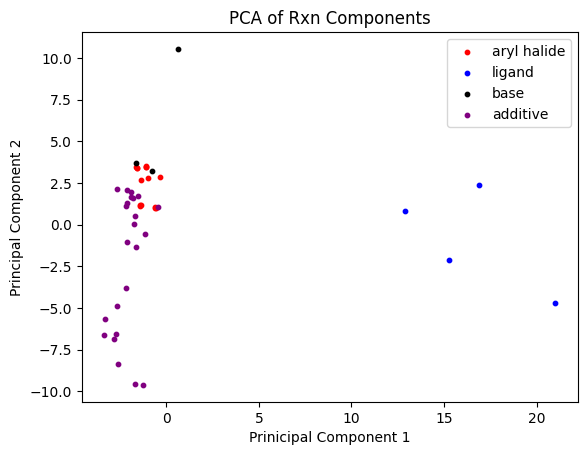

In [14]:
make_pca_plot(pca_df)

In [15]:
df = classify_yields(df)
df

,plate,row,col,base,base_cas_number,base_smiles,ligand,ligand_cas_number,ligand_smiles,aryl_halide_number,aryl_halide,aryl_halide_smiles,additive_number,additive,additive_smiles,product_smiles,yield,class_yield
0,1,1,1,P2Et,165535-45-5,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,XPhos,564483-18-7,CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C3CCCCC3)...,1.0,1-chloro-4-(trifluoromethyl)benzene,FC(F)(F)c1ccc(Cl)cc1,NaN,NaN,NaN,Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1,26.888615,0
1,1,1,2,P2Et,165535-45-5,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,XPhos,564483-18-7,CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C3CCCCC3)...,2.0,1-bromo-4-(trifluoromethyl)benzene,FC(F)(F)c1ccc(Br)cc1,NaN,NaN,NaN,Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1,24.063224,0
2,1,1,3,P2Et,165535-45-5,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,XPhos,564483-18-7,CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C3CCCCC3)...,3.0,1-iodo-4-(trifluoromethyl)benzene,FC(F)(F)c1ccc(I)cc1,NaN,NaN,NaN,Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1,47.515821,1
3,1,1,4,P2Et,165535-45-5,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,XPhos,564483-18-7,CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C3CCCCC3)...,4.0,1-chloro-4-methoxybenzene,COc1ccc(Cl)cc1,NaN,NaN,NaN,COc1ccc(Nc2ccc(C)cc2)cc1,2.126831,0
4,1,1,5,P2Et,165535-45-5,CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC,XPhos,564483-18-7,CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C3CCCCC3)...,5.0,1-bromo-4-methoxybenzene,COc1ccc(Br)cc1,NaN,NaN,NaN,COc1ccc(Nc2ccc(C)cc2)cc1,47.586354,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594,3,32,44,MTBD,84030-20-6,CN1CCCN2CCCN=C12,AdBrettPhos,1160861-59-5,CC(C1=C(C2=C(OC)C=CC(OC)=C2P(C34CC5CC(C4)CC(C5...,12.0,2-iodopyridine,Ic1ccccn1,22.0,methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate,COC(=O)c1cc(on1)c2sccc2,Cc1ccc(Nc2ccccn2)cc1,86.233157,1
4595,3,32,45,MTBD,84030-20-6,CN1CCCN2CCCN=C12,AdBrettPhos,1160861-59-5,CC(C1=C(C2=C(OC)C=CC(OC)=C2P(C34CC5CC(C4)CC(C5...,13.0,3-chloropyridine,Clc1cccnc1,22.0,methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate,COC(=O)c1cc(on1)c2sccc2,Cc1ccc(Nc2cccnc2)cc1,1.440081,0
4596,3,32,46,MTBD,84030-20-6,CN1CCCN2CCCN=C12,AdBrettPhos,1160861-59-5,CC(C1=C(C2=C(OC)C=CC(OC)=C2P(C34CC5CC(C4)CC(C5...,14.0,3-bromopyridine,Brc1cccnc1,22.0,methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate,COC(=O)c1cc(on1)c2sccc2,Cc1ccc(Nc2cccnc2)cc1,43.538365,1
4597,3,32,47,MTBD,84030-20-6,CN1CCCN2CCCN=C12,AdBrettPhos,1160861-59-5,CC(C1=C(C2=C(OC)C=CC(OC)=C2P(C34CC5CC(C4)CC(C5...,15.0,3-iodopyridine,Ic1cccnc1,22.0,methyl-5-(thiophen-2-yl)isoxazole-3-carboxylate,COC(=O)c1cc(on1)c2sccc2,Cc1ccc(Nc2cccnc2)cc1,69.795902,1


In [16]:
df['product_smiles'].unique()

array(['Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1', 'COc1ccc(Nc2ccc(C)cc2)cc1',
       'CCc1ccc(Nc2ccc(C)cc2)cc1', 'Cc1ccc(Nc2ccccn2)cc1',
       'Cc1ccc(Nc2cccnc2)cc1', nan], dtype=object)

In [17]:
len(df)

4599

In [18]:
df.loc[df['product_smiles'] == 'Cc1ccc(Nc2ccc(C(F)(F)F)cc2)cc1', ['class_yield']]

,class_yield
0,0
1,0
2,1
16,0
17,1
...,...
4568,0
4569,1
4583,0
4584,0


In [19]:
rxn_fps = np.load('rxn_fps_inputs.npy')

In [20]:
rxn_fps = StandardScaler().fit_transform(rxn_fps)

In [23]:
labels = df['class_yield']

In [24]:
svc = SVC()

In [25]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
rxn_fps, labels, test_size=0.33, random_state=12
)

In [26]:
svc.fit(train_inputs, train_labels)

SVC()

In [27]:
preds = svc.predict(test_inputs)

In [28]:
preds

array([1, 1, 0, ..., 1, 1, 1])

In [29]:
f1_score(test_labels, preds)

0.792507204610951